In [1]:
!gcloud config set project  bwh-midrc-rapid-res-1655321320

Updated property [core/project].


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
  project_name = "bwh-midrc-rapid-res-1655321320"
  bucket_name = "midrc-analysis-bwh"
  bucket_path = "bpr-results"
  table_name = "radiomics_features"

In [4]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap
import seaborn as sb 
import pandas as pd 


In [5]:
%%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320

WITH
  nlst_instances_per_series AS (
    SELECT
      DISTINCT(StudyInstanceUID),
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
    FROM
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 
  nlst_values_per_series AS (
    SELECT 
    ANY_VALUE(dicom_all.PatientID) AS PatientID,
    dicom_all.SeriesInstanceUID,
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
  FROM
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
  JOIN
    nlst_instances_per_series
  ON
    dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
  WHERE
    min_SliceThickness >= 1.5 
    AND max_SliceThickness <= 3.5 
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false"
  GROUP BY
    SeriesInstanceUID
  )
  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID,
    dicom_all.collection_id,
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    dicom_all.PatientSex,
    dicom_all.PixelSpacing,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness,
    nlst_values_per_series.PatientHeightScanned
  FROM
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
  JOIN
    nlst_values_per_series 
  ON
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID

Query is running:   0%|          |

Downloading:   0%|          |

In [182]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,PixelSpacing,num_instances,SliceThickness,PatientHeightScanned
0,10000364-5672217,2.16.840.1.114274.1818.49248342807445344118392...,2.16.840.1.114274.1818.47345896179707423297865...,2.16.840.1.114274.1818.46291840829412825989916...,Open-A1,023Y,64.955,None,"[0.7421875, 0.7421875]",162,1.5,241.500
1,10000364-5844749,2.16.840.1.114274.1818.46522232248016243346977...,2.16.840.1.114274.1818.54030824719462046157317...,2.16.840.1.114274.1818.50582260801577658486914...,Open-A1,082Y,63.504,None,"[0.50933786078098, 0.509765625]",156,2.0,11.403
2,10000364-1906862,2.16.840.1.114274.1818.47315073017873895969904...,2.16.840.1.114274.1818.54298494434996532488383...,2.16.840.1.114274.1818.48182102849539210181634...,Open-A1,024Y,107.502,None,"[0.583984375, 0.58415841584158]",166,1.5,247.500
3,10000364-5844749,2.16.840.1.114274.1818.46522232248016243346977...,2.16.840.1.114274.1818.48079410346833519191539...,2.16.840.1.114274.1818.56479051596522220001748...,Open-A1,082Y,63.504,None,"[0.751953125, 0.751953125]",122,2.0,280.000
4,10000364-1461701,2.16.840.1.114274.1818.52001131290310374926881...,2.16.840.1.114274.1818.48566219368119807761650...,2.16.840.1.114274.1818.47727408926521179651576...,Open-A1,018Y,60.782,None,"[0.64453125, 0.64453125]",179,1.5,267.000
...,...,...,...,...,...,...,...,...,...,...,...,...
205258,10000364-1380451,2.16.840.1.114274.1818.57618452499506629833358...,2.16.840.1.114274.1818.56853209444716231091565...,2.16.840.1.114274.1818.48110277360746789921718...,Open-A1,087Y,80.06,None,"[0.796875, 0.796875]",140,1.5,246.000
205259,10000364-1380451,2.16.840.1.114274.1818.57618452499506629833358...,2.16.840.1.114274.1818.55681874733043414677313...,2.16.840.1.114274.1818.48612410409509523011535...,Open-A1,087Y,80.06,None,"[0.50390625, 0.50368188512518]",268,1.5,20.890
205260,10000364-1380451,2.16.840.1.114274.1818.57618452499506629833358...,2.16.840.1.114274.1818.55681874733043414677313...,2.16.840.1.114274.1818.51084797147430704942255...,Open-A1,087Y,80.06,None,"[0.50390625, 0.50368188512518]",268,1.5,20.890
205261,10000364-1380451,2.16.840.1.114274.1818.57618452499506629833358...,2.16.840.1.114274.1818.56853209444716231091565...,2.16.840.1.114274.1818.47239411156506925252773...,Open-A1,087Y,80.06,None,"[0.796875, 0.796875]",140,1.5,246.000


In [183]:
ct_limited_open_a1_r1.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'collection_id', 'PatientAge', 'PatientWeight', 'PatientSex',
       'PixelSpacing', 'num_instances', 'SliceThickness',
       'PatientHeightScanned'],
      dtype='object')

In [31]:
ct_limited_open_a1_r1.describe()

,num_instances,SliceThickness,PatientHeightScanned
count,205263.000000,205263.000000,205263.000000
mean,205.543586,1.951141,154.969153
std,130.696102,0.494407,189.016151
min,101.000000,1.500000,0.000000
25%,140.000000,1.500000,0.000000
50%,174.000000,2.000000,14.857000
75%,215.000000,2.000000,298.000000
max,997.000000,3.000000,821.250000


In [184]:
ct_agg = ct_limited_open_a1_r1.groupby('SeriesInstanceUID').first()

In [185]:
ct_agg.columns

Index(['PatientID', 'StudyInstanceUID', 'SOPInstanceUID', 'collection_id',
       'PatientAge', 'PatientWeight', 'PatientSex', 'PixelSpacing',
       'num_instances', 'SliceThickness', 'PatientHeightScanned'],
      dtype='object')

In [157]:
ct_agg

,PatientID,StudyInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,PixelSpacing,num_instances,SliceThickness,PatientHeightScanned,pxspace
SeriesInstanceUID,,,,,,,,,,,,
1.2.826.0.1.3680043.10.474.419639.100940082049547977095875503097,419639-009308,1.2.826.0.1.3680043.10.474.419639.328587506924...,1.2.826.0.1.3680043.10.474.419639.192146551470...,Open-R1,050Y,None,F,"[0.684814453125, 0.684814453125]",116,3.0,0.0,0.684814
1.2.826.0.1.3680043.10.474.419639.104999691526586117030451269512,419639-001303,1.2.826.0.1.3680043.10.474.419639.176312493585...,1.2.826.0.1.3680043.10.474.419639.121666152374...,Open-R1,050Y,None,F,"[0.957031, 0.957031]",163,3.0,0.0,0.957031
1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334,419639-009729,1.2.826.0.1.3680043.10.474.419639.198074364500...,1.2.826.0.1.3680043.10.474.419639.255051392929...,Open-R1,070Y,None,F,"[0.894531, 0.894531]",178,2.5,442.5,0.894531
1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.115458126322...,Open-R1,070Y,None,M,"[0.896484, 0.896484]",180,2.5,447.5,0.896484
1.2.826.0.1.3680043.10.474.419639.106487990095216990796630872774,419639-000650,1.2.826.0.1.3680043.10.474.419639.646688418110...,1.2.826.0.1.3680043.10.474.419639.125527552718...,Open-R1,020Y,None,M,"[0.625, 0.625]",107,3.0,0.0,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...
2.16.840.1.114274.1818.57601950852188244264207831351385225620,10000364-1394148,2.16.840.1.114274.1818.49774922561130556661656...,2.16.840.1.114274.1818.50101807930675063691656...,Open-A1,037Y,122.108,None,"[0.70126227208976, 0.701171875]",133,3.0,0.0,0.701262
2.16.840.1.114274.1818.576253891675188691413500115704969073061,10000364-6578694,2.16.840.1.114274.1818.54477431737773994149193...,2.16.840.1.114274.1818.54443312218197495681629...,Open-A1,072Y,86.183,None,"[0.5859375, 0.5859375]",209,1.5,312.0,0.585938
2.16.840.1.114274.1818.57631685976852387199787819446102366639,10000364-1775416,2.16.840.1.114274.1818.51917729578450709901644...,2.16.840.1.114274.1818.51822346498384140354491...,Open-A1,046Y,136.079,None,"[0.599609375, 0.59940652818991]",191,2.0,0.0,0.599609


In [ ]:
s  = ct_limited_open_a1_r1['StudyInstanceUID'].tolist()
s

In [40]:
x  = ct_limited_open_a1_r1['PixelSpacing'].tolist()

In [41]:
x[0]

array(['0.7421875', '0.7421875'], dtype=object)

In [42]:
pxspace = [k[0] for k in ct_limited_open_a1_r1['PixelSpacing']]

In [43]:
pxspace[:5]

['0.7421875', '0.50933786078098', '0.583984375', '0.751953125', '0.64453125']

In [62]:
ct_limited_open_a1_r1['num_instances']

0         162
1         156
2         166
3         122
4         179
         ... 
205258    140
205259    268
205260    268
205261    140
205262    140
Name: num_instances, Length: 205263, dtype: Int64

In [68]:
ct_limited_open_a1_r1['pxspace']

0         0.742188
1         0.509338
2         0.583984
3         0.751953
4         0.644531
            ...   
205258    0.796875
205259    0.503906
205260    0.503906
205261    0.796875
205262    0.796875
Name: pxspace, Length: 205263, dtype: float64

In [67]:
ct_limited_open_a1_r1['pxspace']=pxspace
ct_limited_open_a1_r1['pxspace'] =ct_limited_open_a1_r1['pxspace'].astype(float)

In [145]:
x1  = ct_limited_open_a1_r1['SliceThickness'].tolist()
#x1

[1.5, 2.0, 2.5, 3]
[84380. 83538. 10368. 26977.]
[41.10823675 40.69803131  5.05108081 13.14265114]


([<matplotlib.patches.Wedge at 0x7fd71d37cc10>,
 [Text(0.3032966073654621, 1.057360472100504, '1.5'),
  Text(-0.8270731084527287, -0.7252241538133856, '2.0'),
  Text(0.6086427984609577, -0.91627176311486, '2.5'),
  Text(1.0075620641348895, -0.4413826989317109, '3.0')],
 [Text(0.16543451310843385, 0.576742075691184, '41%'),
  Text(-0.4511307864287611, -0.3955768111709375, '41%'),
  Text(0.33198698097870416, -0.49978459806265085, '5%'),
  Text(0.5495793077099396, -0.2407541994172968, '13%')])

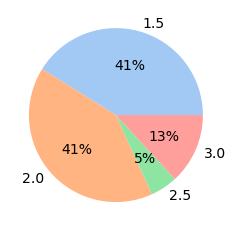

In [142]:
v=ct_limited_open_a1_r1['SliceThickness'].tolist()
vset = set(v)
v_manual = [1.5, 2., 2.5, 3]
eps = 0.1
counts = np.zeros(len(v_manual))
for k in v:
  for i in range(len(v_manual)):
    if abs(k-v_manual[i])<eps:
      counts[i]+=1
print(v_manual)
print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

plt.pie( counts, labels = ['%.1f'%x for x in v_manual], colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})


In [138]:
v1=ct_limited_open_a1_r1['PatientSex'].tolist()
vset = set(v1)
vset

{'F', 'M', None}

[ 17816.   8974. 178473.]
[ 8.67959642  4.37195208 86.9484515 ]


([<matplotlib.patches.Wedge at 0x7fd720d0bcd0>,
 [Text(1.0593585849946807, 0.2962421111153307, 'F'),
  Text(0.8534565879707161, 0.6939826024111725, 'M'),
  Text(-1.008821360634903, -0.4384968213416639, 'None')],
 [Text(0.577831955451644, 0.16158660606290765, '9%'),
  Text(0.4655217752567542, 0.37853596495154856, '4%'),
  Text(-0.550266196709947, -0.23918008436818028, '87%')])

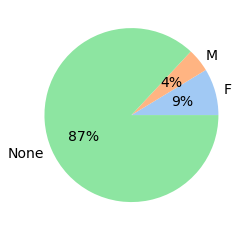

In [139]:
counts = np.zeros(len(vset))
vlist = list(vset)
for k in v1:
    counts[vlist.index(k)]+=1



print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

labels = ['F', 'M', 'None']

plt.pie( counts, labels=labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})

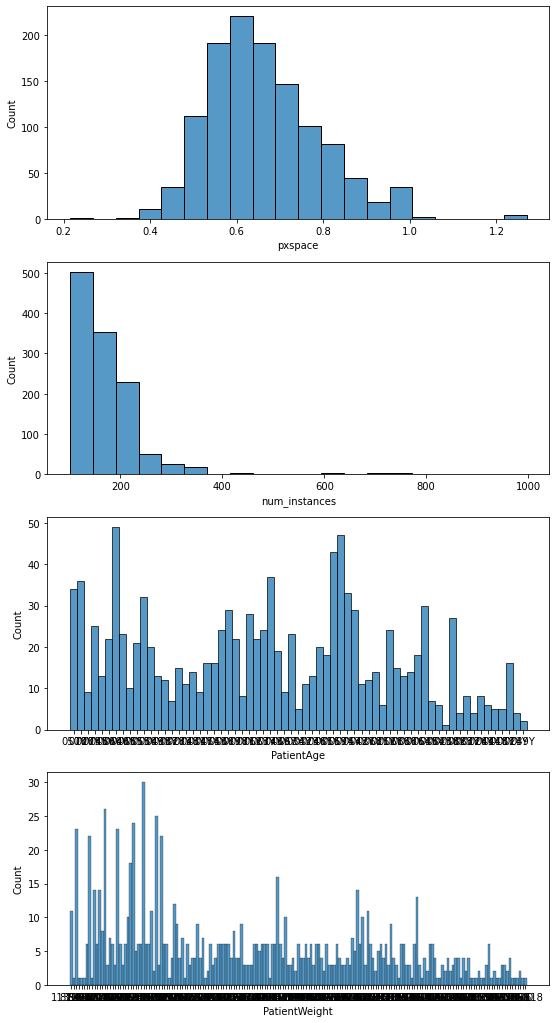

In [179]:
# plot selected

fig, ax = plt.subplots(4, 1, figsize=(9, 18))

x1 = np.random.randint(low=0, high=2, size=20)

# Slice Thickness 
#sb.histplot(ax=ax[0], x="SliceThickness", data=ct_limited_open_a1_r1)

# Slice Resolution 
sb.histplot(ax=ax[0], bins=20, x="pxspace", data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# Number of Slices
sb.histplot(ax=ax[1], bins=20, x="num_instances", data=ct_agg)
#plt.xlim(0,800)

# PatientAge
sb.histplot(ax=ax[2], x="PatientAge", bins = 20, data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# PatientWeight
sb.histplot(ax=ax[3], x="PatientWeight", bins = 20, data=ct_agg)

# BodyPartExamined
#sb.countplot(ax=ax[0], x="BodyPartExamined", data=ct_open_a1_r1)

# PatientSex
#sb.countplot(ax=ax[5], x="PatientSex", data=ct_limited_open_a1_r1)


In [43]:
%%bigquery radiomics_features --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )
SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
radiomics_features

,StudyInstanceUID,Value,viewer_url


In [35]:
radiomics_features.columns

Index(['StudyInstanceUID', 'Value', 'viewer_url'], dtype='object')

In [ ]:
radiomics_features['Value'] = radiomics_features['Value'].astype(float)

flatness = radiomics_features['Value'].tolist()
flatness

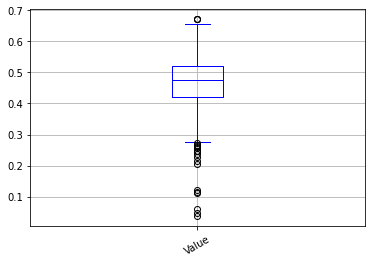

In [21]:
radiomics_features.boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [46]:
%%bigquery radiomics_features_all --project=bwh-midrc-rapid-res-1655321320

SELECT * FROM `bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements` 
#where (Quantity.CodeMeaning = "Flatness" AND 
#      Quantity.CodeMeaning = "SurfaceArea")


Query is running:   0%|          |

Downloading:   0%|          |

In [47]:
radiomics_features_all.columns

Index(['PatientID', 'SOPInstanceUID', 'measurementGroup_number',
       'segmentationInstanceUID', 'segmentationSegmentNumber',
       'sourceSegmentedSeriesUID', 'trackingIdentifier', 'Quantity', 'Value',
       'Units'],
      dtype='object')

In [48]:
radiomics_features_all

,PatientID,SOPInstanceUID,measurementGroup_number,segmentationInstanceUID,segmentationSegmentNumber,sourceSegmentedSeriesUID,trackingIdentifier,Quantity,Value,Units
0,10000364-1234858,1.2.276.0.7230010.3.1.4.481034752.100359.16689...,0,1.2.276.0.7230010.3.1.4.481034752.116154.16675...,[1],2.16.840.1.114274.1818.52624542686710188408392...,Measurements group 1,"{'CodeValue': 'Q3CK', 'CodingSchemeDesignator'...",0.675000000,"{'CodeValue': 'mm', 'CodingSchemeDesignator': ..."
1,10000364-1234858,1.2.276.0.7230010.3.1.4.481034752.100359.16689...,0,1.2.276.0.7230010.3.1.4.481034752.116154.16675...,[1],2.16.840.1.114274.1818.52624542686710188408392...,Measurements group 1,"{'CodeValue': 'N17B', 'CodingSchemeDesignator'...",0.368000000,"{'CodeValue': 'mm', 'CodingSchemeDesignator': ..."
2,10000364-1234858,1.2.276.0.7230010.3.1.4.481034752.100359.16689...,0,1.2.276.0.7230010.3.1.4.481034752.116154.16675...,[1],2.16.840.1.114274.1818.52624542686710188408392...,Measurements group 1,"{'CodeValue': '7J51', 'CodingSchemeDesignator'...",108.277000000,"{'CodeValue': 'mm', 'CodingSchemeDesignator': ..."
3,10000364-1234858,1.2.276.0.7230010.3.1.4.481034752.100359.16689...,0,1.2.276.0.7230010.3.1.4.481034752.116154.16675...,[1],2.16.840.1.114274.1818.52624542686710188408392...,Measurements group 1,"{'CodeValue': 'TDIC', 'CodingSchemeDesignator'...",294.360000000,"{'CodeValue': 'mm', 'CodingSchemeDesignator': ..."
4,10000364-1234858,1.2.276.0.7230010.3.1.4.481034752.100359.16689...,0,1.2.276.0.7230010.3.1.4.481034752.116154.16675...,[1],2.16.840.1.114274.1818.52624542686710188408392...,Measurements group 1,"{'CodeValue': 'L0JK', 'CodingSchemeDesignator'...",353.683000000,"{'CodeValue': 'mm', 'CodingSchemeDesignator': ..."
...,...,...,...,...,...,...,...,...,...,...
10495,10000364-1626259,1.2.276.0.7230010.3.1.4.481034752.99631.166888...,1,1.2.276.0.7230010.3.1.4.481034752.79052.166750...,[2],2.16.840.1.114274.1818.50045102131326508291481...,Measurements group 2,"{'CodeValue': '2PR5', 'CodingSchemeDesignator'...",0.094000000,"{'CodeValue': '/mm', 'CodingSchemeDesignator':..."
10496,10000364-1626259,1.2.276.0.7230010.3.1.4.481034752.99631.166888...,1,1.2.276.0.7230010.3.1.4.481034752.79052.166750...,[2],2.16.840.1.114274.1818.50045102131326508291481...,Measurements group 2,"{'CodeValue': 'YEKZ', 'CodingSchemeDesignator'...",965259.000000000,"{'CodeValue': 'mm3', 'CodingSchemeDesignator':..."
10497,10000364-1626259,1.2.276.0.7230010.3.1.4.481034752.99631.166888...,1,1.2.276.0.7230010.3.1.4.481034752.79052.166750...,[2],2.16.840.1.114274.1818.50045102131326508291481...,Measurements group 2,"{'CodeValue': 'SKGS', 'CodingSchemeDesignator'...",0.020000000,"{'CodeValue': '1', 'CodingSchemeDesignator': '..."
10498,10000364-1626259,1.2.276.0.7230010.3.1.4.481034752.99631.166888...,1,1.2.276.0.7230010.3.1.4.481034752.79052.166750...,[2],2.16.840.1.114274.1818.50045102131326508291481...,Measurements group 2,"{'CodeValue': 'BQWJ', 'CodingSchemeDesignator'...",0.142000000,"{'CodeValue': '1', 'CodingSchemeDesignator': '..."


In [49]:
# test

In [ ]:
%%bigquery radiomics_features_test --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )

SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

In [50]:
%%bigquery test --project=bwh-midrc-rapid-res-1655321320
SELECT * FROM bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements


Query is running:   0%|          |

Downloading:   0%|          |

In [54]:
test.Quantity[0]

{'CodeValue': 'Q3CK',
 'CodingSchemeDesignator': 'IBSI',
 'CodeMeaning': 'Elongation'}

In [55]:
tq_list = test['Quantity'].tolist()

In [57]:
tq_meaning = [t['CodeMeaning'] for t in tq_list]

In [62]:
test['CodeMeaning']  = tq_meaning
test['CodeMeaning']= test['CodeMeaning'].astype(str)

In [65]:
test.columns

Index(['PatientID', 'SOPInstanceUID', 'measurementGroup_number',
       'segmentationInstanceUID', 'segmentationSegmentNumber',
       'sourceSegmentedSeriesUID', 'trackingIdentifier', 'Quantity', 'Value',
       'Units', 'CodeMeaning'],
      dtype='object')

In [66]:
len(set(test.sourceSegmentedSeriesUID))

374

In [69]:
len(set(test.CodeMeaning))

14

In [81]:
set(test.Value)

{Decimal('0.625000000'),
 Decimal('0.500000000'),
 Decimal('0.125000000'),
 Decimal('2.000000000'),
 Decimal('0.875000000'),
 Decimal('0.750000000'),
 Decimal('0.375000000'),
 Decimal('1.750000000'),
 Decimal('267.772000000'),
 Decimal('2499810.042000000'),
 Decimal('72638.469000000'),
 Decimal('426012.000000000'),
 Decimal('1156352.917000000'),
 Decimal('299.147000000'),
 Decimal('1268582.708000000'),
 Decimal('753734.000000000'),
 Decimal('852042.000000000'),
 Decimal('140851.814000000'),
 Decimal('94.125000000'),
 Decimal('94.375000000'),
 Decimal('2022276.083000000'),
 Decimal('102.000000000'),
 Decimal('102.875000000'),
 Decimal('2162797.000000000'),
 Decimal('111.750000000'),
 Decimal('114.375000000'),
 Decimal('127.000000000'),
 Decimal('852096.000000000'),
 Decimal('134.000000000'),
 Decimal('135.750000000'),
 Decimal('137.750000000'),
 Decimal('1137581.083000000'),
 Decimal('148.000000000'),
 Decimal('1573013.000000000'),
 Decimal('152.375000000'),
 Decimal('153.750000000'),
 

In [94]:
df_total = pd.DataFrame()
for cm in set(test.CodeMeaning):
  print(cm)
  df = test[test.CodeMeaning == cm]
  df = df.groupby('sourceSegmentedSeriesUID').first()
  #print(df.Value)
  df_cm = pd.DataFrame(columns = ['sourceSegmentedSeriesUID','Value','CodeMeaning'])
  #print(df_cm)
  df_cm['sourceSegmentedSeriesUID'] = list(df.index.values)
  df_cm['Value'] = df.Value.tolist()
  df_cm['Value'] = df_cm['Value'].astype(float)
  df_cm['CodeMeaning'] = cm
  df_total = df_total.append(df_cm)
  #break

Elongation
Maximum 3D Diameter of a Mesh
Sphericity
Surface Area of Mesh
Surface to Volume Ratio
Spherical Disproportion
Major Axis in 3D Length
Volume from Voxel Summation
Flatness
Compactness 1
Minor Axis in 3D Length
Volume of Mesh
Compactness 2
Least Axis in 3D Length


In [89]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,0.502000000,Elongation
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,0.682000000,Elongation
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,0.780000000,Elongation
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,0.524000000,Elongation
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,0.622000000,Elongation
...,...,...,...
369,2.16.840.1.114274.1818.54352507480550551635792...,116.855000000,Least Axis in 3D Length
370,2.16.840.1.114274.1818.54368937193612837791934...,89.983000000,Least Axis in 3D Length
371,2.16.840.1.114274.1818.54523201253294416831269...,129.002000000,Least Axis in 3D Length
372,2.16.840.1.114274.1818.54529809498757879121319...,85.952000000,Least Axis in 3D Length


In [90]:
374*14

5236

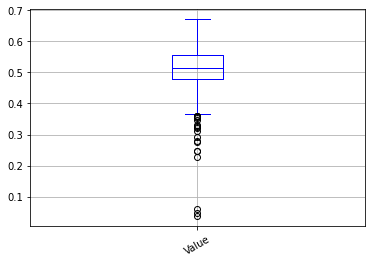

In [96]:
df_total[df_total.CodeMeaning=='Flatness'].boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [97]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,0.502,Elongation
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,0.682,Elongation
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,0.780,Elongation
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,0.524,Elongation
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,0.622,Elongation
...,...,...,...
369,2.16.840.1.114274.1818.54352507480550551635792...,116.855,Least Axis in 3D Length
370,2.16.840.1.114274.1818.54368937193612837791934...,89.983,Least Axis in 3D Length
371,2.16.840.1.114274.1818.54523201253294416831269...,129.002,Least Axis in 3D Length
372,2.16.840.1.114274.1818.54529809498757879121319...,85.952,Least Axis in 3D Length


In [98]:
df_total.columns

Index(['sourceSegmentedSeriesUID', 'Value', 'CodeMeaning'], dtype='object')

In [101]:
col_list = ['sourceSegmentedSeriesUID'] + list(set(df_total.CodeMeaning))
df_total_by_feature = pd.DataFrame(columns=col_list)
df_total_by_feature

,sourceSegmentedSeriesUID,Elongation,Maximum 3D Diameter of a Mesh,Sphericity,Surface to Volume Ratio,Surface Area of Mesh,Spherical Disproportion,Major Axis in 3D Length,Volume from Voxel Summation,Flatness,Compactness 1,Minor Axis in 3D Length,Volume of Mesh,Compactness 2,Least Axis in 3D Length


In [102]:
for cm in set(df_total.CodeMeaning):
  df = df_total[df_total.CodeMeaning == cm]
  df_total_by_feature.sourceSegmentedSeriesUID = list(df.index.values)
  df_total_by_feature[cm] = df.Value
  df_total_by_feature[cm] = df_total_by_feature[cm].astype(float)

In [103]:
df_total_by_feature

,sourceSegmentedSeriesUID,Elongation,Maximum 3D Diameter of a Mesh,Sphericity,Surface to Volume Ratio,Surface Area of Mesh,Spherical Disproportion,Major Axis in 3D Length,Volume from Voxel Summation,Flatness,Compactness 1,Minor Axis in 3D Length,Volume of Mesh,Compactness 2,Least Axis in 3D Length
0,0,0.502,184.968,0.495,0.129,55626.157,2.020,191.605,429913.0,0.248,0.018,96.279,429726.042,0.121,47.540
1,1,0.682,261.851,0.599,0.067,117152.431,1.668,212.918,1749793.0,0.439,0.025,145.162,1749570.292,0.215,93.452
2,2,0.780,311.657,0.580,0.053,203823.060,1.723,256.166,3826321.0,0.487,0.023,199.769,3826057.542,0.196,124.805
3,3,0.524,240.568,0.501,0.093,104843.058,1.996,239.929,1132623.0,0.324,0.019,125.691,1132342.875,0.126,77.816
4,4,0.622,140.922,0.566,0.115,46928.178,1.766,129.972,407310.0,0.565,0.023,80.874,407151.458,0.181,73.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,369,0.955,233.758,0.558,0.067,147003.516,1.793,191.959,2207596.0,0.609,0.022,183.390,2207327.875,0.173,116.855
370,370,0.820,236.620,0.502,0.088,116880.048,1.993,187.802,1336120.0,0.479,0.019,153.936,1335710.167,0.126,89.983
371,371,0.908,245.748,0.514,0.072,161853.210,1.947,192.136,2253396.0,0.671,0.020,174.526,2253141.417,0.135,129.002
372,372,0.689,175.097,0.525,0.101,76347.230,1.906,162.914,753734.0,0.528,0.020,112.243,753553.000,0.144,85.952


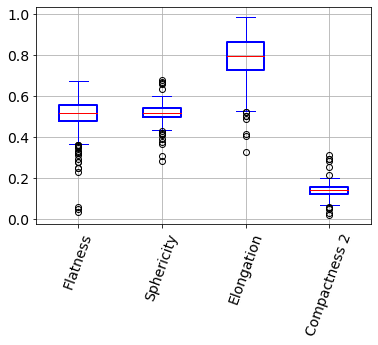

In [149]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Flatness','Sphericity','Elongation', 'Compactness 2'],  color='blue',fontsize=14, rot=70, boxprops=boxprops, medianprops=medianprops)

In [152]:
fig_fn = '\content\boxplot1.png'
plt.savefig(fig_fn)

<Figure size 432x288 with 0 Axes>

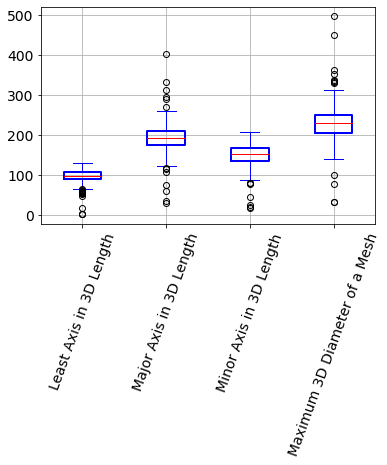

In [150]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Least Axis in 3D Length','Major Axis in 3D Length','Minor Axis in 3D Length','Maximum 3D Diameter of a Mesh'], grid='false', color='blue',fontsize=14, rot=70,boxprops=boxprops, medianprops=medianprops )

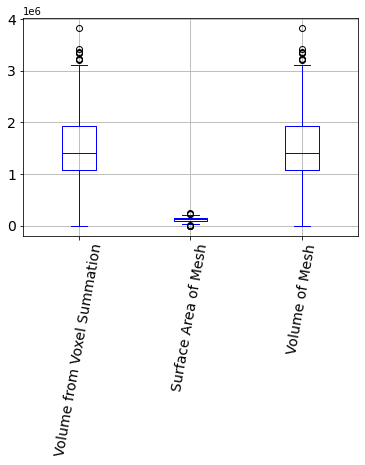

In [131]:
df_total_by_feature.boxplot( column = ['Volume from Voxel Summation','Surface Area of Mesh','Volume of Mesh'], grid='false', color='blue',fontsize=14, rot=80 )
